In [56]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
data = pd.read_csv('/kaggle/input/btc-dataset/gemini_BTCUSD_2020_1min.csv')

In [50]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


BTC-2017min.csv contains all the 1 Minute historical data of 2020, this dataset contains columns including Unix Timestamp, dates, Symbol, opening, high, low, closing, Volume (Crypto) and Volume Base Ccy. code up your first kernel: LSTMs and Deep Reinforcement Learning agents works well for this dataset. Don't forget to up-vote 👍 **Currency in BTC-USD
<br>
About each Column:
<ul>
<li>Unix Timestamp - This is the unix timestamp or also known as "Epoch Time". Use this to convert to your local timezone</li>
<li>Date - This timestamp is UTC Timezone</li>
<li>Symbol - The symbol for which the timeseries data refers</li>
<li>Open - This is the opening price of the time period</li>
<li>High - This is the highest price of the time period</li>
<li>Low - This is the lowest price of the time period</li>
<li>Close - This is the closing price of the time period</li>
<li>Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount</li>

</ul>


In [59]:
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


In [60]:
data = data.iloc[: , 3:]

In [61]:
data.head()

,Open,High,Low,Close,Volume
0,55717.47,55723.00,55541.69,55541.69,2.406734
1,55768.94,55849.82,55711.74,55717.47,0.573458
2,55691.79,55793.15,55691.79,55768.94,3.309904
3,55777.86,55777.86,55677.92,55691.79,0.684934
4,55803.50,55823.88,55773.08,55777.86,0.477225


In [62]:
data.shape

(658065, 5)

In [63]:
scaler = MinMaxScaler().fit(data)

In [64]:
Data = scaler.transform(data)

In [65]:
Data.shape

(658065, 5)

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [67]:
class Data_Gen(Dataset):
    def __init__(self, data, window, prediction, step,min_index, max_index):
        self.data = data
        self.window = window
        self.prediction = prediction
        self.step = step
        self.min_index = min_index
        self.max_index = max_index
    def __len__(self):
        return (self.max_index - self.min_index - self.window - self.prediction - 1)
    def __getitem__(self, index):
        start_index = index + self.min_index
        end_index = start_index + self.window
        indices = range(start_index, end_index, self.step)

        samples = np.zeros((len(indices), 4))  # Assuming 4 features (columns)
        
        for j, idx in enumerate(indices):
            samples[j] = self.data[idx, 1:]  # Features from columns 1 onward
        
        targets = self.data[idx + self.prediction, 0]  # Target is column 0
        samples = torch.from_numpy(samples).float()
        targets = torch.tensor(targets, dtype=torch.float32)  # Convert scalar to tensor

        return samples, targets

In [68]:
window = 1440
predcition = 10
step = 1
batch = 32


In [69]:
Train_dataset = Data_Gen(data = Data, window =window, prediction = predcition,step= step, min_index =200000, max_index=300000)
Val_dataset = Data_Gen(data = Data, window =window, prediction = predcition,step= step, min_index =300000, max_index=400000)
Test_dataset = Data_Gen(data = Data, window =window, prediction = predcition,step= step, min_index = 400001,max_index= 500000)

In [70]:
Train_loader = DataLoader(Train_dataset, batch_size = batch, shuffle = True)
Val_loader = DataLoader(Val_dataset, batch_size = batch, shuffle = True)
Test_loader = DataLoader(Test_dataset, batch_size = batch, shuffle = True)

In [111]:
class RNN1(nn.Module):
    def __init__(self):
        super(RNN1, self).__init__()
        self.gru1 = nn.GRU(4, 32, batch_first=True, bidirectional= False , num_layers = 1)
        self.gru2 = nn.GRU(32, 32, batch_first = True)
        self.flat = nn.Flatten()
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
       out1, out2 = self.gru1(x)
       out1, out2 = self.gru2(out1)
       out = self.flat(out2.squeeze())
       out = self.dense(out)

       return out

In [112]:
class CNN_RNN(nn.Module):
    def __init__(self):
        super(CNN_RNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 64, kernel_size=7)  # Input channels = 4 (from features), output channels = 64
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization for Conv1d
        self.dropout1 = nn.Dropout(0.5)  # Dropout after first convolution
        self.max_pool1 = nn.MaxPool1d(kernel_size=5)  
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)  # Second conv layer
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization for Conv1d
        self.dropout2 = nn.Dropout(0.5)  # Dropout after first convolution
        self.max_pool2 = nn.MaxPool1d(kernel_size=5) 

        self.gru1 = nn.GRU(128, 64, batch_first=True, bidirectional=False, num_layers=1)  # Input size = 128 (CNN output channels)
        self.gru2 = nn.GRU(64, 32, batch_first=True)
        self.dropout_gru = nn.Dropout(0.5)  # Dropout after first convolution

        self.flat = nn.Flatten()
        self.dense = nn.Linear(32, 1)  # Output a single value (regression)

    def forward(self, x):
        # CNN layers
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len) for Conv1d
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.max_pool2(x)

        # GRU layers
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, input_size) for GRU
        out1, _ = self.gru1(x)
        _, out2 = self.gru2(out1)
        out2 = self.dropout_gru(out2)
        

        # Flatten and Dense layer
    
        out = self.flat(out2.squeeze())
        out = self.dense(out)

        return out


In [113]:
model = CNN_RNN().to(device)

In [114]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


## Training using the CNN with RNN model

In [115]:
num_epochs = 40 
steps_per_epoch = 40  # Number of batches to process in each epoch

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    trainning_loss = 0.0
    for idx, (samples, targets) in enumerate(Train_loader):
        if idx == steps_per_epoch:
            break  # Stop after processing 40 batches
        samples, targets = samples.to(device), targets.to(device)
        optimizer.zero_grad()  # Reset gradients
        predictions = model(samples)  # Forward pass
        loss = loss_function(predictions, targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        trainning_loss += loss.item() 
    avg_train_loss = trainning_loss / steps_per_epoch
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for ix, (data, targets_val) in enumerate(Val_loader):
            if ix == steps_per_epoch:
                break  # Stop after processing 40 batches
            data, targets_val = data.to(device), targets_val.to(device)
            predictions_val = model(data)
            loss_ = loss_function(predictions_val, targets_val)
            val_loss += loss_.item()
    avg_val_loss =val_loss / steps_per_epoch
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 1/40, Train Loss: 0.0870, Val Loss: 0.0016
Epoch 2/40, Train Loss: 0.0444, Val Loss: 0.0076
Epoch 3/40, Train Loss: 0.0286, Val Loss: 0.0025
Epoch 4/40, Train Loss: 0.0190, Val Loss: 0.0034
Epoch 5/40, Train Loss: 0.0148, Val Loss: 0.0016
Epoch 6/40, Train Loss: 0.0130, Val Loss: 0.0014
Epoch 7/40, Train Loss: 0.0111, Val Loss: 0.0027
Epoch 8/40, Train Loss: 0.0090, Val Loss: 0.0033
Epoch 9/40, Train Loss: 0.0084, Val Loss: 0.0015
Epoch 10/40, Train Loss: 0.0084, Val Loss: 0.0019
Epoch 11/40, Train Loss: 0.0078, Val Loss: 0.0009
Epoch 12/40, Train Loss: 0.0070, Val Loss: 0.0026
Epoch 13/40, Train Loss: 0.0070, Val Loss: 0.0015
Epoch 14/40, Train Loss: 0.0062, Val Loss: 0.0024
Epoch 15/40, Train Loss: 0.0061, Val Loss: 0.0006
Epoch 16/40, Train Loss: 0.0054, Val Loss: 0.0017
Epoch 17/40, Train Loss: 0.0055, Val Loss: 0.0026
Epoch 18/40, Train Loss: 0.0054, Val Loss: 0.0013
Epoch 19/40, Train Loss: 0.0048, Val Loss: 0.0009
Epoch 20/40, Train Loss: 0.0048, Val Loss: 0.0028
Epoch 21/

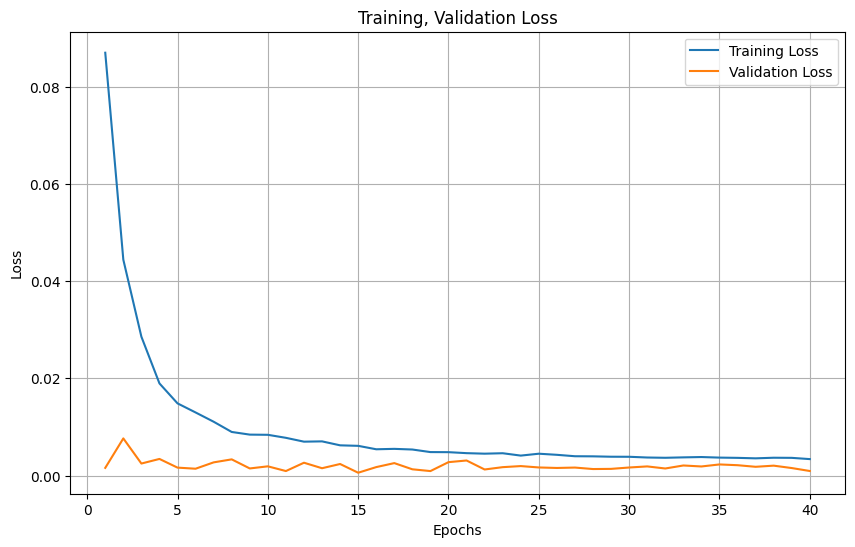

In [116]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [117]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_losses =  []

with torch.no_grad():  # Disable gradient computation for evaluation        
    for idx,( data_test, test_targets) in enumerate(Test_loader):
        data_test, test_targets = data_test.to(device), test_targets.to(device)
        
        test_prediction = model(data_test)  # Forward pass
        loss = loss_function(test_prediction, test_targets)  # Calculate the loss
        test_loss += loss.item()  # Accumulate the loss
        test_losses.append(loss.item())

# Average the test loss over all batches
avg_test_loss = test_loss/len(Test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.0018


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



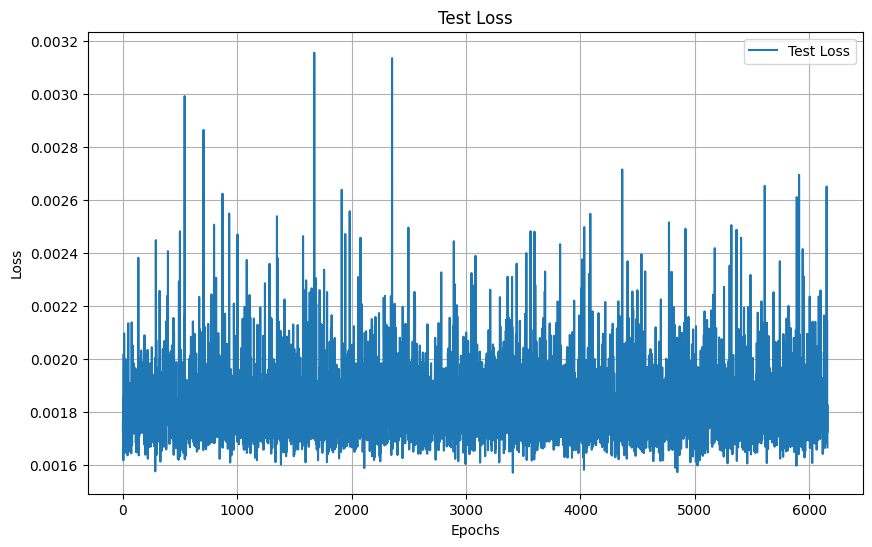

In [118]:

# Plot test loss
plt.figure(figsize=(10, 6))
nbr = len(test_losses)
plt.plot(range(1, nbr+1 ), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

In [119]:
class CNN_RNN_Optimizer(nn.Module):
    def __init__(self, conv1_out_channels, conv2_out_channels, gru1_hidden_size, gru2_hidden_size, dropout_rate= 0.5):
        super(CNN_RNN_Optimizer, self).__init__()
        self.conv1 = nn.Conv1d(4, conv1_out_channels, kernel_size=7)  # Input channels = 4 (from features), output channels = 64
        self.bn1 = nn.BatchNorm1d(conv1_out_channels)  # Batch normalization for Conv1d
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout after first convolution
        self.max_pool1 = nn.MaxPool1d(kernel_size=5) 
        
        self.conv2 = nn.Conv1d(conv1_out_channels, conv2_out_channels, kernel_size=5)  # Second conv layer
        self.bn2 = nn.BatchNorm1d(conv2_out_channels)  # Batch normalization for Conv1d
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout after second convolution
        self.max_pool2 = nn.MaxPool1d(kernel_size=5) 

        self.gru1 = nn.GRU(conv2_out_channels, gru1_hidden_size, batch_first=True, bidirectional=False, num_layers=1)  # Input size = 128 (CNN output channels)
        self.gru2 = nn.GRU(gru1_hidden_size, gru2_hidden_size, batch_first=True)
        self.dropout_gru = nn.Dropout(dropout_rate)  # Dropout after GRU layers


        self.flat = nn.Flatten()
        self.dense = nn.Linear(gru2_hidden_size, 1)  # Output a single value (regression)

        # Initialize weights
        self.initialize_weights()
        
    #Dense ou Convolution
    def initialize_weights(self):
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                nn.init.constant_(module.bias, 0)
            if isinstance(module, nn.GRU):
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)

    def forward(self, x):
        # CNN layers
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len) for Conv1d
        x = self.conv1(x)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)  # Apply batch normalization
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.max_pool2(x)

        # GRU layers
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, input_size) for GRU
        out1, _ = self.gru1(x)
        _, out2 = self.gru2(out1)
        out2 = self.dropout_gru(out2)  # Apply dropout after GRU


        # Flatten and Dense layer
    
        out = self.flat(out2.squeeze())
        out = self.dense(out)

        return out


In [120]:
def objective(trial):
    # Hyperparameters to optimize
    conv1_out_channels = trial.suggest_int("conv1_out_channels", 32, 128)
    conv2_out_channels = trial.suggest_int("conv2_out_channels", 64, 256)
    gru1_hidden_size = trial.suggest_int("gru1_hidden_size", 32, 128)
    gru2_hidden_size = trial.suggest_int("gru2_hidden_size", 16, 64)
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Data Preparation
    Train_loader = DataLoader(Train_dataset, batch_size = batch_size, shuffle = True)
    Val_loader = DataLoader(Val_dataset, batch_size = batch_size, shuffle = True)

    # Model and optimizer
    model = CNN_RNN_Optimizer(conv1_out_channels, conv2_out_channels, gru1_hidden_size, gru2_hidden_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    model.train()
    for epoch in range(5):  # Train for a few epochs
         for idx, (data, target) in enumerate(Train_loader):
            if idx == steps_per_epoch:
                break  # Stop after processing 40 batches
    
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for ix, (data, target) in enumerate(Val_loader):
            if ix == steps_per_epoch:
                break  # Stop after processing 40 batches
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
    # Return validation loss
    return val_loss / len(Val_loader)


In [121]:
import optuna
steps_per_epoch = 40

# Create and optimize the study
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=20)  # Number of trials

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  Loss: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-01-12 12:49:32,164] A new study created in memory with name: no-name-0fa547ff-e008-4b7b-8517-c3c8f3627294
<ipython-input-120-aa390eb84403>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-01-12 12:49:36,523] Trial 0 finished with value: 2.3339708300168298e-05 and parameters: {'conv1_out_channels': 91, 'conv2_out_channels': 190, 'gru1_hidden_size': 107, 'gru2_hidden_size': 25, 'lr': 0.0031909402653611035, 'batch_size': 16}. Best is trial 0 with value: 2.3339708300168298e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

[I 2025-01-12 12:49:51,389] Trial 1 finished with value: 5

Best trial:
  Loss: 2.6805232700063277e-06
  Params: 
    conv1_out_channels: 119
    conv2_out_channels: 67
    gru1_hidden_size: 33
    gru2_hidden_size: 36
    lr: 0.0005939488357308957
    batch_size: 16


In [122]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()


In [123]:
# Retrieve the best parameters
best_params = study.best_trial.params

# Example: Print the best parameters
print("Best parameters found:")
for key, value in best_params.items():
    print(f"{key}: {value}")


Best parameters found:
conv1_out_channels: 119
conv2_out_channels: 67
gru1_hidden_size: 33
gru2_hidden_size: 36
lr: 0.0005939488357308957
batch_size: 16


In [124]:
best_model = CNN_RNN_Optimizer(
    conv1_out_channels=best_params["conv1_out_channels"],
    conv2_out_channels=best_params["conv2_out_channels"],
    gru1_hidden_size=best_params["gru1_hidden_size"],
    gru2_hidden_size=best_params["gru2_hidden_size"]
).to(device)

# Define the optimizer with the best learning rate
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])

# Define the loss function
criterion = nn.MSELoss()
best_batch_size = best_params["batch_size"]


Train_loader = DataLoader(Train_dataset, batch_size = best_batch_size, shuffle = True)
Val_loader = DataLoader(Val_dataset, batch_size = best_batch_size, shuffle = True)

In [125]:
num_epochs = 40 
steps_per_epoch = 40  # Number of batches to process in each epoch

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    best_model.train()
    trainning_loss = 0.0
    for idx, (samples, targets) in enumerate(Train_loader):
        if idx == steps_per_epoch:
            break  # Stop after processing 40 batches
        samples, targets = samples.to(device), targets.to(device)

        optimizer.zero_grad()  # Reset gradients
        predictions = best_model(samples)  # Forward pass
        loss = criterion(predictions, targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        trainning_loss += loss.item() 
    avg_train_loss = trainning_loss / steps_per_epoch
    train_losses.append(avg_train_loss)

    # Validation loop
    best_model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for ix, (data, targets_val) in enumerate(Val_loader):
            if ix == steps_per_epoch:
                break  # Stop after processing 40 batches
            data, targets_val = data.to(device), targets_val.to(device)

            predictions_val = best_model(data)
            loss_ = criterion(predictions_val, targets_val)
            val_loss += loss_.item()
    avg_val_loss =val_loss / steps_per_epoch
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 1/40, Train Loss: 0.3193, Val Loss: 0.0003
Epoch 2/40, Train Loss: 0.1069, Val Loss: 0.0039
Epoch 3/40, Train Loss: 0.0656, Val Loss: 0.0006
Epoch 4/40, Train Loss: 0.0304, Val Loss: 0.0009
Epoch 5/40, Train Loss: 0.0236, Val Loss: 0.0005
Epoch 6/40, Train Loss: 0.0174, Val Loss: 0.0011
Epoch 7/40, Train Loss: 0.0170, Val Loss: 0.0005
Epoch 8/40, Train Loss: 0.0124, Val Loss: 0.0008
Epoch 9/40, Train Loss: 0.0113, Val Loss: 0.0014
Epoch 10/40, Train Loss: 0.0103, Val Loss: 0.0007
Epoch 11/40, Train Loss: 0.0092, Val Loss: 0.0009
Epoch 12/40, Train Loss: 0.0089, Val Loss: 0.0004
Epoch 13/40, Train Loss: 0.0074, Val Loss: 0.0004
Epoch 14/40, Train Loss: 0.0074, Val Loss: 0.0003
Epoch 15/40, Train Loss: 0.0071, Val Loss: 0.0003
Epoch 16/40, Train Loss: 0.0064, Val Loss: 0.0005
Epoch 17/40, Train Loss: 0.0058, Val Loss: 0.0010
Epoch 18/40, Train Loss: 0.0062, Val Loss: 0.0004
Epoch 19/40, Train Loss: 0.0059, Val Loss: 0.0003
Epoch 20/40, Train Loss: 0.0064, Val Loss: 0.0003
Epoch 21/

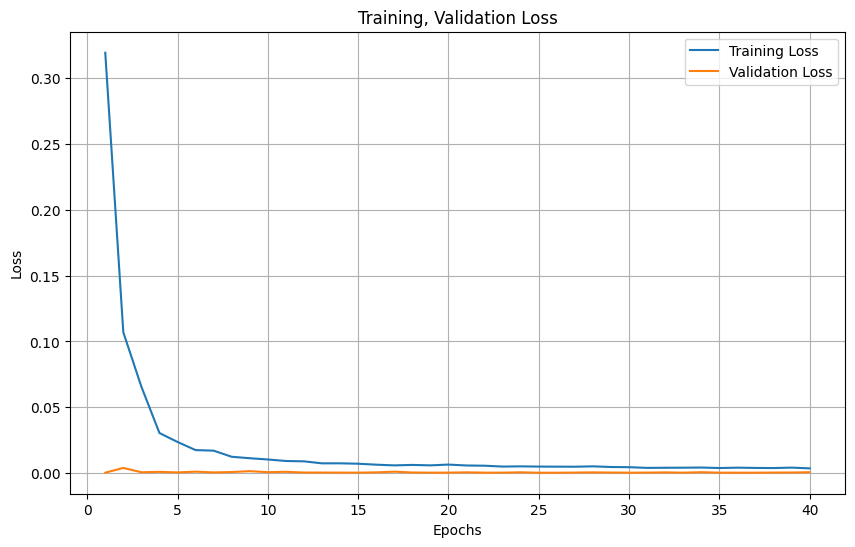

In [126]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [127]:
Test_loader = DataLoader(Test_dataset, batch_size = best_batch_size, shuffle = True)

In [128]:
best_model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_losses =  []

with torch.no_grad():  # Disable gradient computation for evaluation        
    for idx,( data_test, test_targets) in enumerate(Test_loader):
        data_test, test_targets = data_test.to(device), test_targets.to(device)

        test_prediction = best_model(data_test)  # Forward pass
        loss = criterion(test_prediction, test_targets)  # Calculate the loss
        test_loss += loss.item()  # Accumulate the loss
        test_losses.append(loss.item())

# Average the test loss over all batches
avg_test_loss = test_loss/len(Test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.0024


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



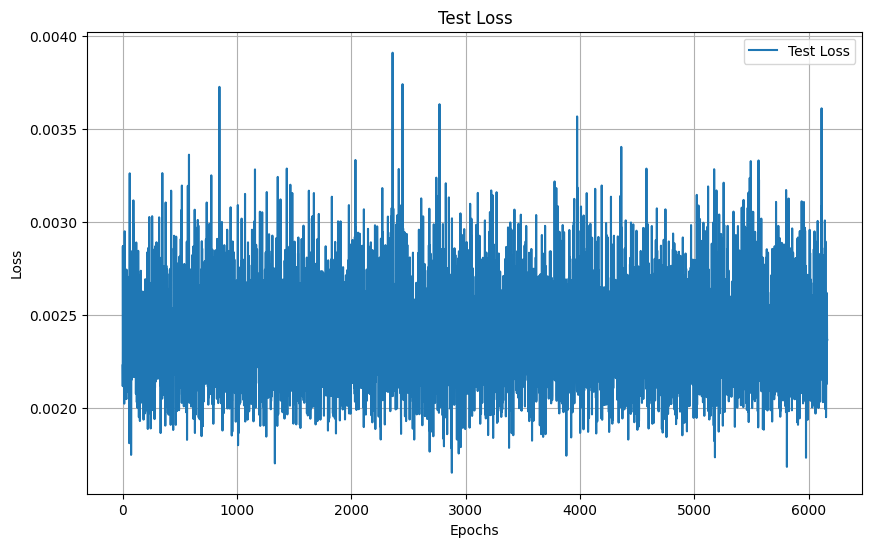

In [129]:

# Plot training and validation loss
plt.figure(figsize=(10, 6))
nbr = len(test_losses)
plt.plot(range(1, nbr+1 ), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.grid(True)
plt.show()